---
title: Utilities - Complex and Real Formats
---

In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 1. Use retina for crisp, PDF-like text that never disappears in HTML
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# 2. Set a high baseline DPI
plt.rcParams["figure.dpi"] = 150


Magnetic Resonance signals are inherently complex-valued, consisting of both Real and Imaginary components (representing the X and Y magnetization vectors in the rotating frame).

However, many modern data pipelines—specifically **Machine Learning frameworks like PyTorch and TensorFlow**—do not uniformly support complex data types across all of their layers and loss functions.

To feed MR data into these networks, a standard workaround is to split the 1D complex array into a 2D real-valued array, essentially treating the Real and Imaginary components as two separate "channels" (much like RGB channels in an image).

`xmris` provides fluid utilities to transition back and forth between these representations while preserving all coordinates and metadata.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Ensure the accessor is imported so .xmr is registered
import xmris

## 1. Creating a Complex Array
Let's start by simulating a standard, complex-valued Free Induction Decay (FID).

In [ ]:
# Generate a simple synthetic complex FID
t = np.linspace(0, 1, 512)
freq = 15.0  # Hz
decay = 3.0
complex_fid = np.exp(-t * decay) * np.exp(1j * 2 * np.pi * freq * t)

da_complex = xr.DataArray(
    complex_fid,
    dims=["Time"],
    coords={"Time": t},
    attrs={"sequence": "FID", "B0": 3.0},
    name="Signal",
)

print("Original DataArray:")
print(f"Shape: {da_complex.shape}")
print(f"Data Type: {da_complex.dtype}")
da_complex

Original DataArray:
Shape: (512,)
Data Type: complex128
<xarray.DataArray 'Signal' (Time: 512)> Size: 8kB
array([ 1.00000000e+00+0.00000000e+00j,  9.77285126e-01+1.82320498e-01j,
        9.21845454e-01+3.56358221e-01j,  8.35934443e-01+5.16334911e-01j,
        7.22807859e-01+6.57014412e-01j,  5.86602175e-01+7.73873101e-01j,
        4.32184652e-01+8.63244272e-01j,  2.64980507e-01+9.22431908e-01j,
        9.07832640e-02+9.49790361e-01j, -8.44451176e-02+9.44767643e-01j,
       -2.54777464e-01+9.07911289e-01j, -4.14521064e-01+8.40837045e-01j,
       -5.58407099e-01+7.46161850e-01j, -6.81763552e-01+6.27403818e-01j,
       -7.80665955e-01+4.88852949e-01j, -8.52061139e-01+3.35417311e-01j,
       -8.93860129e-01+1.72450138e-01j, -9.04997404e-01+5.56393154e-03j,
       -8.85454921e-01-1.59562029e-01j, -8.36250495e-01-3.17374180e-01j,
       -7.59391352e-01-4.62630672e-01j, -6.57794819e-01-5.90574684e-01j,
       -5.35179223e-01-6.97089333e-01j, -3.95929020e-01-7.78829179e-01j,
       -2.44939019

## 2. Splitting into Real and Imaginary Channels

Using `.xmr.to_real_imag()`, we can expand this array. The function will stack the real and imaginary components along a brand new dimension (defaulting to `"Complex"`).

Notice how the data type changes from `complex128` to `float64`, and the shape expands from `(512,)` to `(512, 2)`.

In [ ]:
da_split = da_complex.xmr.to_real_imag()

print("Split DataArray:")
print(f"Shape: {da_split.shape}")
print(f"Data Type: {da_split.dtype}")
da_split

Split DataArray:
Shape: (512, 2)
Data Type: float64
<xarray.DataArray 'Signal' (Time: 512, Complex: 2)> Size: 8kB
array([[ 1.00000000e+00,  0.00000000e+00],
       [ 9.77285126e-01,  1.82320498e-01],
       [ 9.21845454e-01,  3.56358221e-01],
       ...,
       [ 4.69865295e-02, -1.81636043e-02],
       [ 4.92308338e-02, -9.18441290e-03],
       [ 4.97870684e-02, -5.36673119e-16]])
Coordinates:
  * Time     (Time) float64 4kB 0.0 0.001957 0.003914 ... 0.9961 0.998 1.0
  * Complex  (Complex) <U4 32B 'Real' 'Imag'
Attributes:
    sequence:  FID
    B0:        3.0


Because this is still an `xarray.DataArray`, we can easily plot the two channels side-by-side using standard xarray plotting utilities.

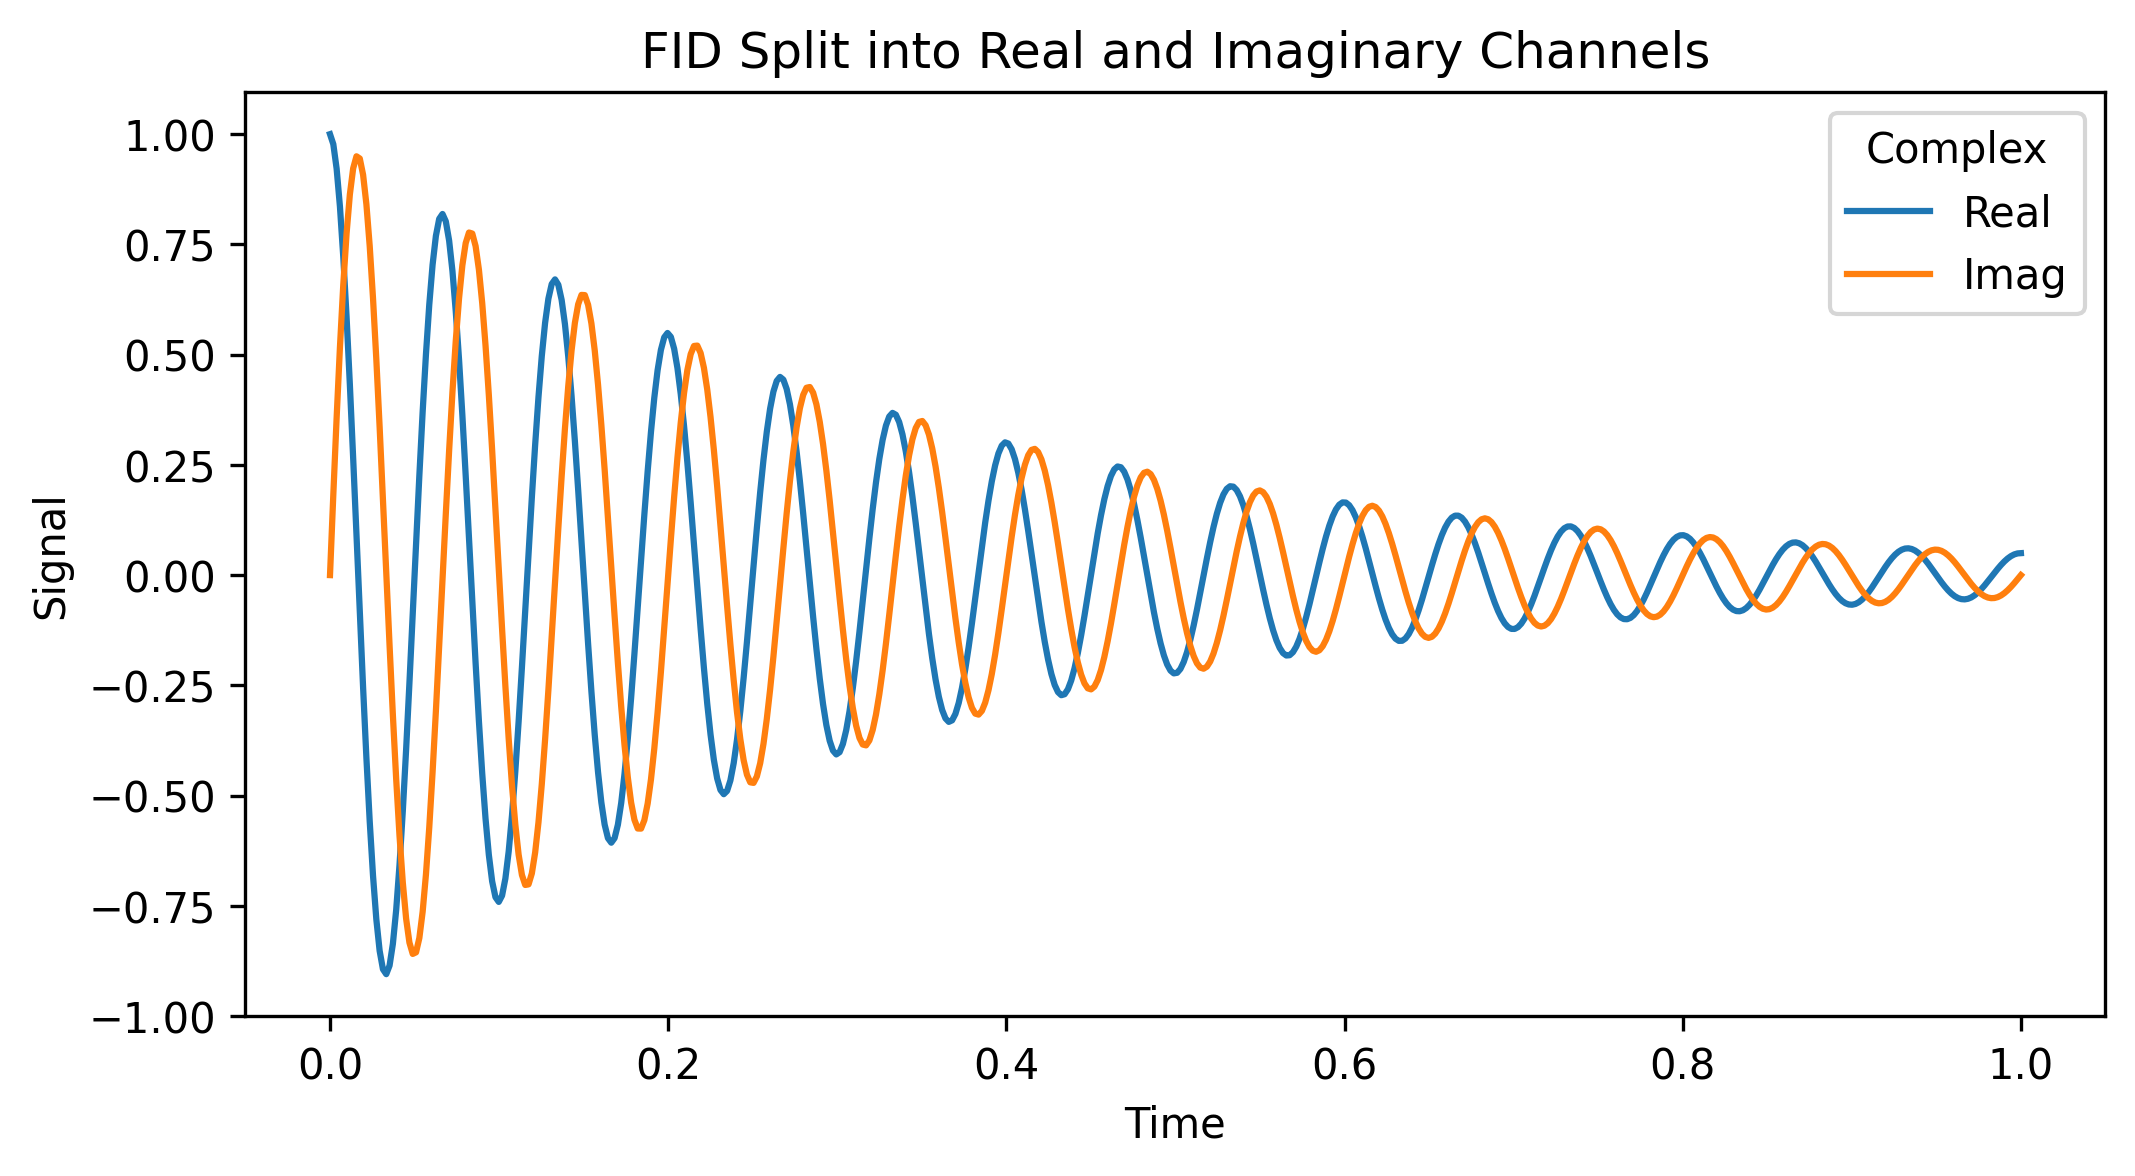

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
da_split.plot.line(ax=ax, x="Time", hue="Complex")
ax.set_title("FID Split into Real and Imaginary Channels")
plt.show()

## 3. Reconstructing the Complex Array

After running your data through a neural network or saving it to a legacy file format, you will likely need to reconstruct it into a proper complex array to perform standard signal processing (like an FFT or phase correction).

We use `.xmr.to_complex()` to collapse the dimension back down.

In [6]:
da_reconstructed = da_split.xmr.to_complex()

print("Reconstructed DataArray:")
print(f"Shape: {da_reconstructed.shape}")
print(f"Data Type: {da_reconstructed.dtype}")

# Prove mathematically that we recovered the exact original data
is_identical = np.allclose(da_complex.values, da_reconstructed.values)
print(f"\nExact recovery successful: {is_identical}")

Reconstructed DataArray:
Shape: (512,)
Data Type: complex128

Exact recovery successful: True


In [7]:
# STRICT TESTS FOR CI
# 1. Test splitting dimensionality and types
assert da_split.ndim == da_complex.ndim + 1, "Dimension was not added."
assert da_split.sizes["Complex"] == 2, "Complex dimension should have size 2."
assert not np.iscomplexobj(da_split.values), "Split array should be strictly real."
assert da_split.name == da_complex.name, "Name attribute lost."
assert da_split.attrs["sequence"] == "FID", "Attributes were lost."

# 2. Test coordinate labels
assert list(da_split.coords["Complex"].values) == ["Real", "Imag"], (
    "Coordinate labels incorrect."
)

# 3. Test mathematical accuracy of split
np.testing.assert_array_equal(da_split.sel(Complex="Real").values, da_complex.real.values)
np.testing.assert_array_equal(da_split.sel(Complex="Imag").values, da_complex.imag.values)

# 4. Test reconstruction dimensionality and types
assert da_reconstructed.ndim == da_complex.ndim, (
    "Reconstruction failed to drop dimension."
)
assert np.iscomplexobj(da_reconstructed.values), "Reconstructed array should be complex."
assert "Complex" not in da_reconstructed.dims, "Complex dimension was not fully dropped."

# 5. Test reconstruction mathematical purity
np.testing.assert_array_equal(
    da_reconstructed.values,
    da_complex.values,
    err_msg="Reconstructed complex values do not match original.",
)
assert da_reconstructed.attrs["B0"] == 3.0, "Reconstruction lost attributes."

# 6. Test custom dimension and labels
da_custom = da_complex.xmr.to_real_imag(dim="Channel", labels=("R", "I"))
assert "Channel" in da_custom.dims
assert list(da_custom.coords["Channel"].values) == ["R", "I"]
da_custom_recon = da_custom.xmr.to_complex(dim="Channel", labels=("R", "I"))
np.testing.assert_array_equal(da_custom_recon.values, da_complex.values)